In [ ]:
#SHIVANI TIWARI
CUSTOMER CHURN ANALYSIS CODECLAUSE INTERSHIP TASK-2

import numpy as np # linear algebra
import pandas as pd # data processing, 


In [ ]:
# Libraries used for vsualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-whitegrid")
%matplotlib inline

#library used to split data to avoid overfitting
from sklearn.model_selection import train_test_split

#library used to handle imbalanced dataset
from imblearn.over_sampling import SMOTE

#import library used for counting the number of observations
from collections import Counter

#libraries required to train models
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from xgboost import XGBClassifier

#library used for corss validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

#library used to get metrics to understand model performance
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

#library used to plot random forest model trees
from sklearn.tree import export_graphviz

#library for hyperparameter tuning
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

pd.pandas.set_option('display.max_columns',None)

In [ ]:
df_data = pd.read_csv('/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [ ]:
df_data.shape

(7043, 21)

In [ ]:
#Check for null values
df_data.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

## Feature description:
* 'customerID': Customer ID
* 'gender': Whether the customer is a male or a female
* 'SeniorCitizen': Whether the customer is a senior citizen or not (1, 0)
* 'Partner': Whether the customer has a partner or not (Yes, No)
* 'Dependents': Whether the customer has dependents or not (Yes, No)
* 'tenure': Number of months the customer has stayed with the company
* 'PhoneService': Whether the customer has a phone service or not (Yes, No)
* 'MultipleLines': Whether the customer has multiple lines or not (Yes, No, No phone service)
* 'InternetService': Customer’s internet service provider (DSL, Fiber optic, No)
* 'OnlineSecurity': Whether the customer has online security or not (Yes, No, No internet service)
* 'OnlineBackup': Whether the customer has online backup or not (Yes, No, No internet service)
* 'DeviceProtection': Whether the customer has device protection or not (Yes, No, No internet service)
* 'TechSupport': Whether the customer has tech support or not (Yes, No, No internet service)
* 'StreamingTV': Whether the customer has streaming TV or not (Yes, No, No internet service)
* 'StreamingMovies': Whether the customer has streaming movies or not (Yes, No, No internet service)
* 'Contract': The contract term of the customer (Month-to-month, One year, Two year)
* 'PaperlessBilling': Whether the customer has paperless billing or not (Yes, No)
* 'PaymentMethod': The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
* 'MonthlyCharges': The amount charged to the customer monthly
* 'TotalCharges': The total amount charged to the customer
* 'Churn': Whether the customer churned or not (Yes or No)


* **'Churn' is the target feature**


## Data cleaning

### The feature 'TotalCharges' has float values but it's data type is object. So we will check on this.
First we will find the index positions that have the space(i.e missing value). Then we will replace the spaces with null value and convert the data-type of 'TotalCharges' feature to 'float64'. Next we will impute the missing values with the median value of this feature.

In [ ]:
#Index of rows that have a blank space i.e. it is a null value
na_index = df_data[df_data['TotalCharges'].apply(lambda x: x.isspace())==True].index
print(na_index)

Int64Index([488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754], dtype='int64')


In [ ]:
# Fill the 11 blank values with the np.nan
df_data['TotalCharges'] = df_data['TotalCharges'].replace(' ', np.nan)

#Convert to float type
df_data['TotalCharges'] = df_data['TotalCharges'].astype('float64')

In [ ]:
#Replace the 11 missing values with median of the feature
df_data['TotalCharges']=df_data['TotalCharges'].fillna(df_data['TotalCharges'].median())

In [ ]:
# Drop customerID feature as it is not required
df_data.drop('customerID', axis=1, inplace=True)

In [ ]:
#Apart from 'SeniorCitizen' feature, all the other features have values like Yes/No. So we will map 0 to No and 1 to Yes for the 'SeniorCitizen' feature.
df_data['SeniorCitizen']=df_data['SeniorCitizen'].map({0:'No', 1:'Yes'})

In [ ]:
df_data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## EDA

### Check the data distribution of Target feature

In [ ]:
df_data['Churn'].value_counts()

#### This is an imbalanced data as the number of 'No' is far greater than the number of 'Yes' in our dataset
#### 73% data is for 'No' and remaining 27% data is for 'Yes'

In [ ]:
# Getting categorical and numerical features
cat_cols = [cname for cname in df_data.columns if df_data[cname].dtype=='object' and cname!='Churn']
num_cols = [cname for cname in df_data.columns if df_data[cname].dtype!='object']

print('categorical features: ', cat_cols)
print('numerical features: ', num_cols)

### Univariate analysis

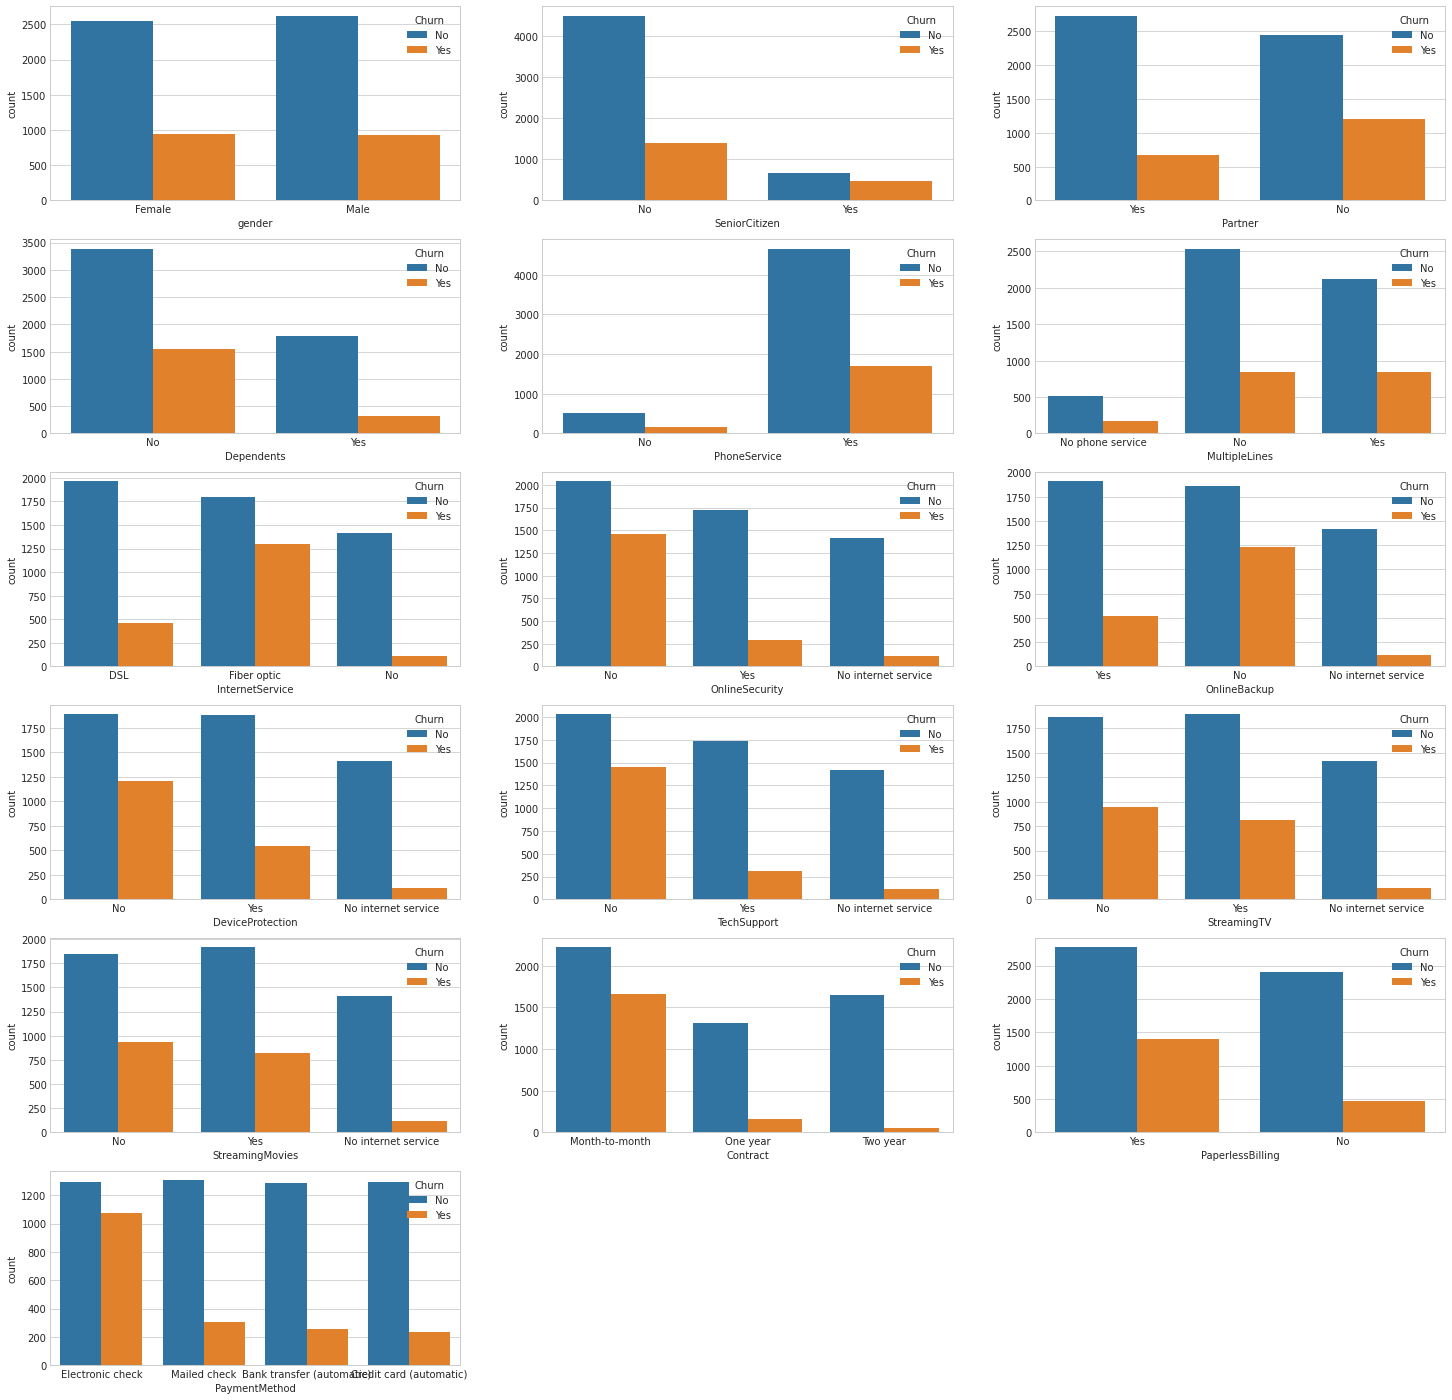

In [ ]:
#Plotting the impact of categorical features on 'Churn'
plt.figure(figsize=(25,25))
for i,cat in enumerate(cat_cols):
    plt.subplot(6,3,i+1)
    sns.countplot(data = df_data, x= cat, hue = "Churn")
plt.show()

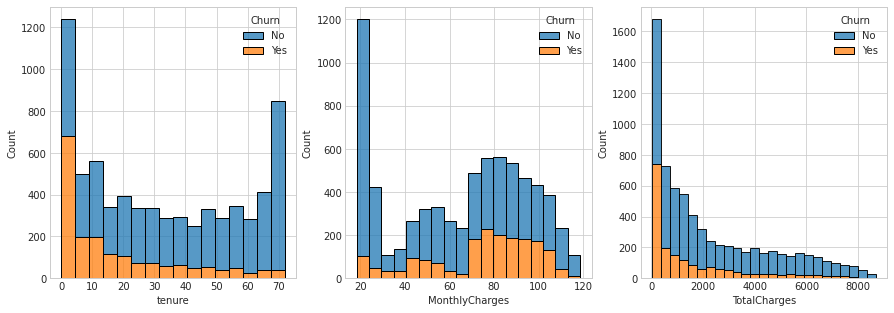

In [ ]:
# Plotting the impact of continuous features on 'Churn'
plt.figure(figsize=(15,5))
for j,con in enumerate(num_cols):
    plt.subplot(1,3,j+1)
    sns.histplot(data = df_data, x= con, hue = "Churn", multiple="stack")
plt.show()

In [ ]:
#We will try to create groups based on the 'tenure' feature
df_data['tenure'].describe()

count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64

In [ ]:
df_data['tenure_grp'] = pd.cut(df_data['tenure'], bins=[0,12,24,36,48,60,np.inf], labels=['0-12', '13-24', '25-36', '37-48', '49-60', '60+'])

In [ ]:
df_data['tenure_grp'].value_counts()

0-12     2175
60+      1407
13-24    1024
25-36     832
49-60     832
37-48     762
Name: tenure_grp, dtype: int64

<AxesSubplot:xlabel='tenure_grp', ylabel='count'>

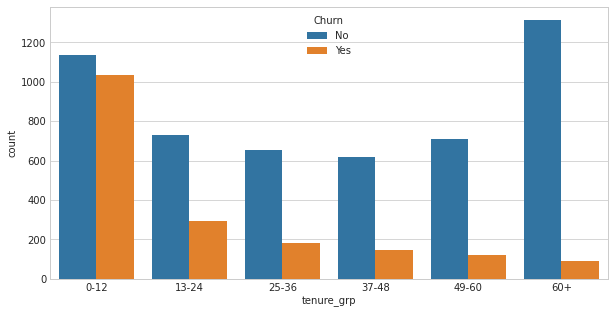

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(data=df_data, x='tenure_grp',hue = "Churn")

In [ ]:
df_data.drop('tenure', axis=1, inplace=True)

In [ ]:
df_data.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_grp
0,Female,No,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0-12
1,Male,No,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,25-36
2,Male,No,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,0-12
3,Male,No,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,37-48
4,Female,No,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0-12


In [ ]:
#Mapping target feature
df_data['Churn']=df_data['Churn'].map({'No':0, 'Yes':1})

In [ ]:
#convert categorical data into dummy variables
df_data_dummy = pd.get_dummies(df_data,drop_first=True)
df_data_dummy.head()

,MonthlyCharges,TotalCharges,Churn,gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_grp_13-24,tenure_grp_25-36,tenure_grp_37-48,tenure_grp_49-60,tenure_grp_60+
0,29.85,29.85,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
1,56.95,1889.50,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0
2,53.85,108.15,1,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
3,42.30,1840.75,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
4,70.70,151.65,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0


<AxesSubplot:xlabel='MonthlyCharges', ylabel='TotalCharges'>

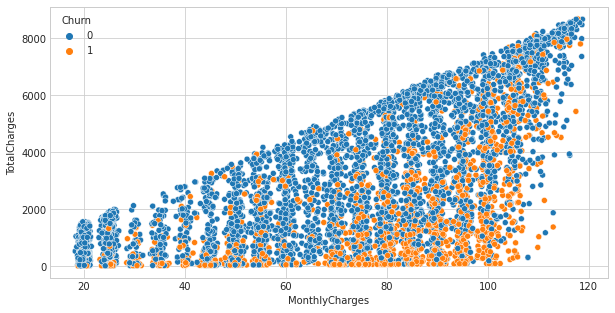

In [ ]:
plt.figure(figsize=(10,5))
sns.scatterplot(x='MonthlyCharges', y='TotalCharges', data=df_data_dummy, hue='Churn')

Insight:
Total charges increase as the Monthly charges increase

<AxesSubplot:>

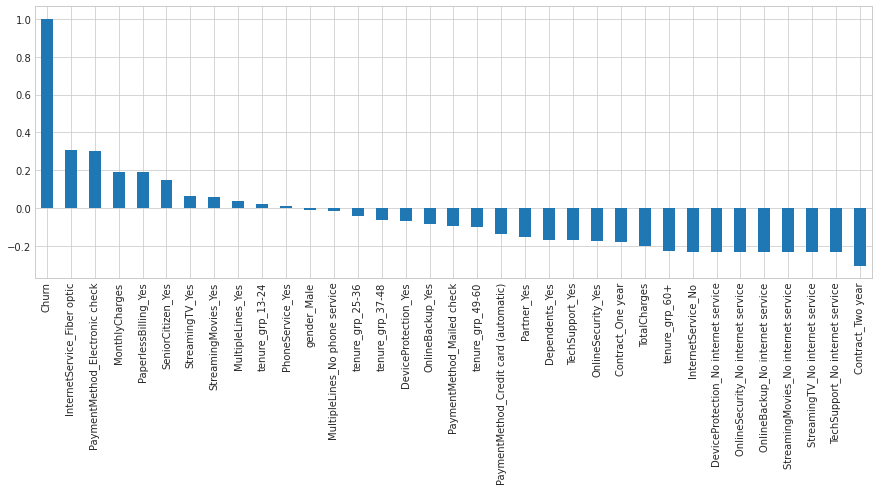

In [ ]:
plt.figure(figsize=(15,5))
df_data_dummy.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')

## Model building

In [ ]:
df_data_model = df_data_dummy.copy(deep=True)
df_data_model.head()

,MonthlyCharges,TotalCharges,Churn,gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_grp_13-24,tenure_grp_25-36,tenure_grp_37-48,tenure_grp_49-60,tenure_grp_60+
0,29.85,29.85,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
1,56.95,1889.50,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0
2,53.85,108.15,1,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
3,42.30,1840.75,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
4,70.70,151.65,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0


In [ ]:
#Seperate independent and dependent features

#X will contain all the independent features
X = df_data_model.loc[:, df_data_model.columns!='Churn']

#y will contain the target i.e dependent feature
y = df_data_model['Churn']

X.shape, y.shape

((7043, 34), (7043,))

SMOTE is an abbreviation for Synthetic Minority Oversampling Technique.

SMOTE works by randomly picking a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.

In [ ]:
smote = SMOTE()
# fit predictor and target variable
X_smote, y_smote = smote.fit_resample(X,y)
print('Original dataset shape', Counter(y))
print('Resample dataset shape', Counter(y_smote))

Original dataset shape Counter({0: 5174, 1: 1869})
Resample dataset shape Counter({0: 5174, 1: 5174})


In [ ]:
# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X_smote, y_smote, train_size=0.7, test_size=0.3, random_state=0)
# summarize
print('Train', X_train.shape, y_train.shape)
print('Test', X_valid.shape, y_valid.shape)

Train (7243, 34) (7243,)
Test (3105, 34) (3105,)


In [ ]:
#adaboost model training
ada_clf = AdaBoostClassifier(random_state=0)

#xgboost model training
xgb_clf = XGBClassifier(n_estimators=1000, learning_rate=0.05)

#randomforest model training
rf_clf = RandomForestClassifier(n_estimators=1000)

In [ ]:
#we will use k-fold cross validation
kfold = KFold(n_splits = 10)

In [ ]:
results = cross_val_score(ada_clf, X_train, y_train, cv = kfold)
print('AdaBoost: ',results.mean())

AdaBoost:  0.8243895980186702


In [ ]:
results2 = cross_val_score(xgb_clf, X_train, y_train, cv = kfold)
print('XGBoost: ',results2.mean())

XGBoost:  0.8441278338731187


In [ ]:
results3 = cross_val_score(rf_clf, X_train, y_train, cv = kfold)
print('RandomForest: ',results3.mean())

RandomForest:  0.8420586778433987


### We will now try to train a RandomForest classifier model

In [ ]:
rf_model = RandomForestClassifier(n_estimators=1000)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000)

In [ ]:
#make predictions
y_pred = rf_model.predict(X_valid)

In [ ]:
print('Model accuracy score: ',accuracy_score(y_valid,y_pred))
print('Confusion matrix: ')
print(confusion_matrix(y_valid,y_pred))
print(classification_report(y_valid,y_pred))

Model accuracy score:  0.8412238325281803
Confusion matrix: 
[[1276  271]
 [ 222 1336]]
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1547
           1       0.83      0.86      0.84      1558

    accuracy                           0.84      3105
   macro avg       0.84      0.84      0.84      3105
weighted avg       0.84      0.84      0.84      3105



## Hyperparameter tuning

In [ ]:
params={
    "n_estimators": [500,700,900,1000,1200,1500],
    "criterion": ['entropy', 'gini'],
    
}

In [ ]:
grid_search =  GridSearchCV(estimator=rf_model, param_grid=params, cv=10, n_jobs=-1,verbose=0)

In [ ]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(n_estimators=1000),
             n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'n_estimators': [500, 700, 900, 1000, 1200, 1500]})

In [ ]:
best_grid = grid_search.best_estimator_
print(best_grid)

RandomForestClassifier(criterion='entropy', n_estimators=1000)


In [ ]:
y_pred = best_grid.predict(X_valid)

In [ ]:
print('Model accuracy score: ',accuracy_score(y_valid,y_pred))
print('Confusion matrix: ')
print(confusion_matrix(y_valid,y_pred))
print(classification_report(y_valid,y_pred))

Model accuracy score:  0.8396135265700483
Confusion matrix: 
[[1271  276]
 [ 222 1336]]
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1547
           1       0.83      0.86      0.84      1558

    accuracy                           0.84      3105
   macro avg       0.84      0.84      0.84      3105
weighted avg       0.84      0.84      0.84      3105

